In [20]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from modeling import optimize
from itertools import product
np.random.seed(42)

In [21]:
df = pd.read_csv('data/processed/clean_and_filled.csv')

`types` is a dataframe containing all features available on the dataset and a respective feature type belonging to one of the following:
- `G` - Genetic/Intrinsic feature (uncontrollable fetures like sex and age)
- `E` - Environmental/Behavioural feature (features that can be controlled, even if slightly, like blood sugar and smoking)
- `H` - Information based on medical history (purely historical information, like previous episodes of chest pain)
- `T` - Test result (tests that require any kind of medical equipment like blood pressure monitors)
- `TP` - Test parameter (condition under which a test has been conducted)
- `CT` - "Cheap" test (tests or checks that can be performed without specific medical equipment)

In [22]:
types = pd.read_csv('data/processed/feature_types.csv').dropna()

In [23]:
types

,feature,feature_type
0,sex_F,G
1,sex_M,G
2,cp_type_atypical_angina,H
3,cp_type_no_pain,H
4,cp_type_non_anginal,H
5,cp_type_typical_angina,H
6,rest_ecg_hypertrophy,T
7,rest_ecg_normal,T
8,rest_ecg_st-t_abnormal,T
9,ex_protocol_100.0,TP


# Question 2
Do genetic/instrinsic factors play a larger role than environmental/behavioral ones?

In [24]:
model_constructor = GradientBoostingClassifier

In [25]:
genetic_cols = list(types.groupby('feature_type').get_group('G')['feature']) 
environmental_cols = list(types.groupby('feature_type').get_group('E')['feature']) 

Training models...: 100%|██████████| 120/120 [00:19<00:00,  6.15it/s]


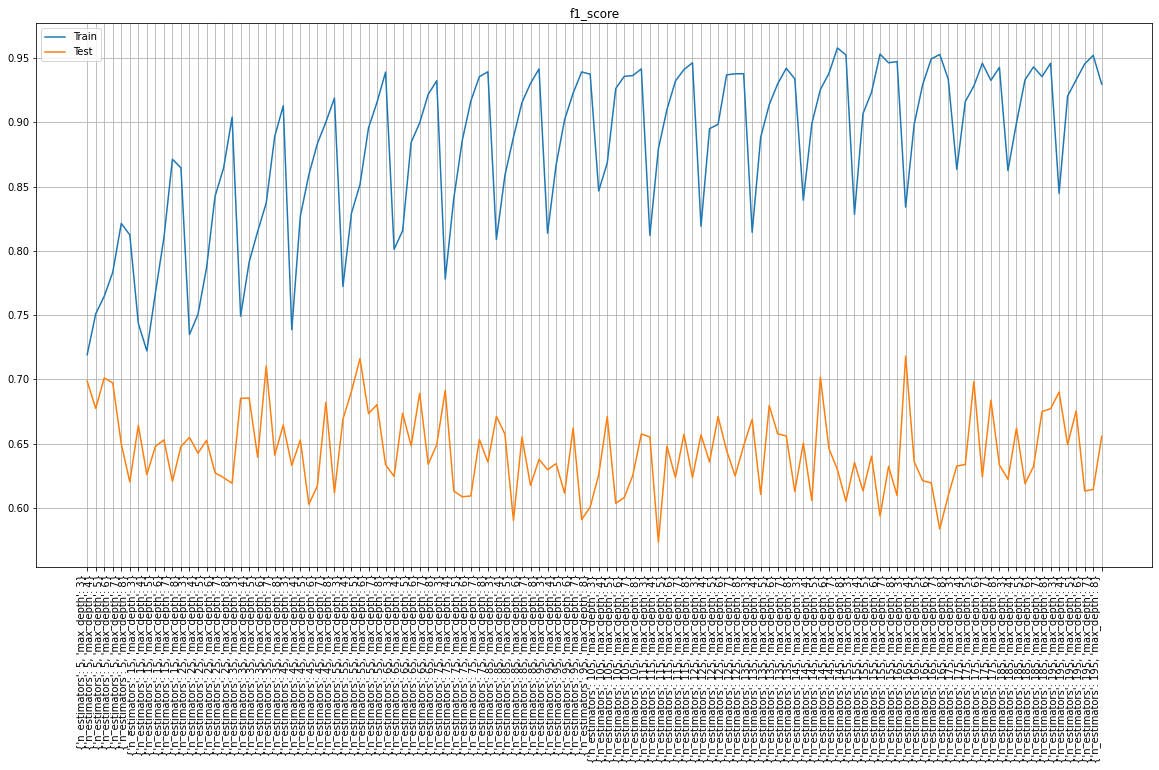

In [26]:
env_params = [{'n_estimators': n, 'max_depth': d} for n, d in product(np.arange(5, 201, 10), np.arange(3, 9))]
env_model, env_training, env_score, env_param = optimize(df[environmental_cols + ['target']], 0.3, model_constructor, env_params, plot=True)

In [27]:
print(environmental_cols)
env_score

['chol', 'smoker', 'smoker_cigs_per_day', 'smoker_years', 'fasting_blood_sugar']


{'f1_score': 0.7181208053691275,
 'accuracy_score': 0.6888888888888889,
 'precision_score': 0.7379310344827587,
 'recall_score': 0.6993464052287581}

Training models...: 100%|██████████| 120/120 [00:16<00:00,  7.09it/s]


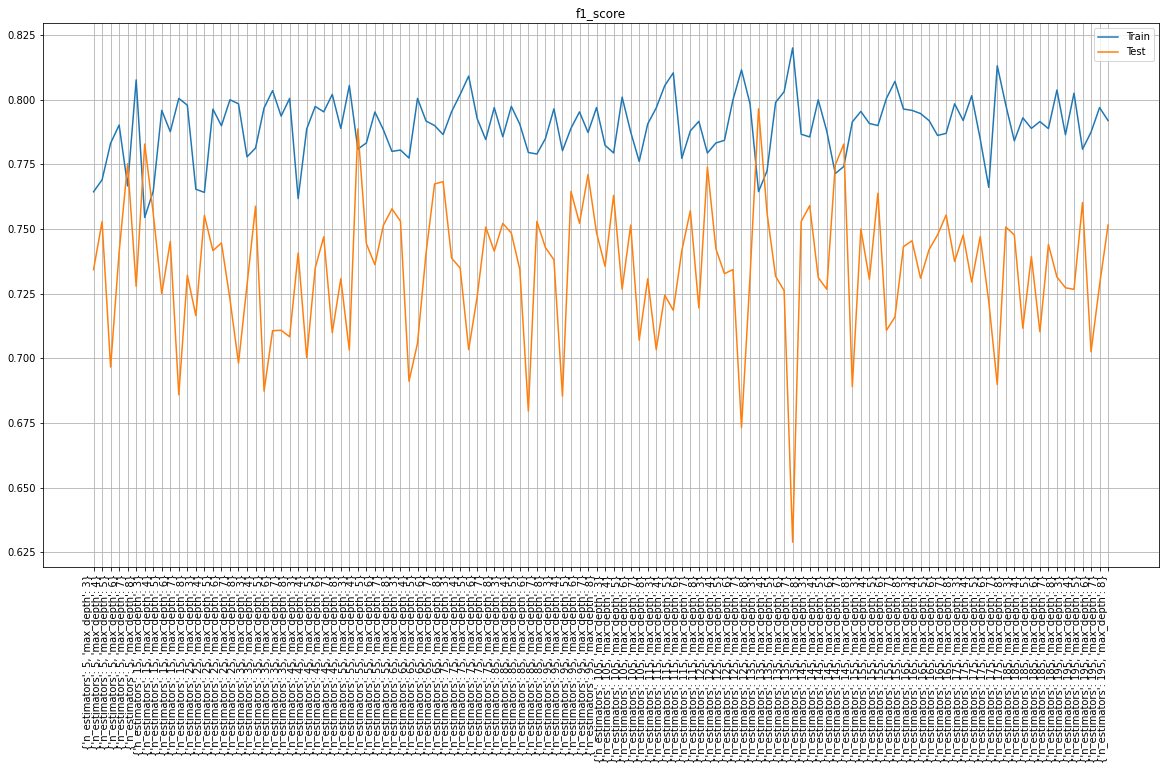

In [28]:
gen_params = [{'n_estimators': n, 'max_depth': d} for n, d in product(np.arange(5, 201, 10), np.arange(3, 9))]
gen_model, gen_training, gen_score, gen_param = optimize(df[genetic_cols + ['target']], 0.3, model_constructor, gen_params, plot=True)

In [29]:
print(genetic_cols)
gen_score

['sex_F', 'sex_M', 'age', 'heart_disease_family']


{'f1_score': 0.7965116279069767,
 'accuracy_score': 0.7407407407407407,
 'precision_score': 0.7569060773480663,
 'recall_score': 0.8404907975460123}

                  genetic  environmental
f1_score         0.796512       0.718121
accuracy_score   0.740741       0.688889
precision_score  0.756906       0.737931
recall_score     0.840491       0.699346


(0.0, 1.0)

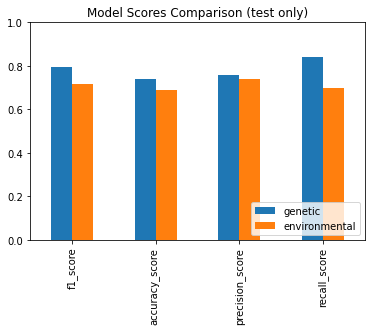

In [30]:
performance_df = pd.DataFrame([gen_score, env_score], index=['genetic', 'environmental']).T
print(performance_df)
performance_df.plot.bar()
plt.title('Model Scores Comparison (test only)')
plt.legend(loc=4)
plt.ylim([0, 1])

# Question 3
Is there a simple or low-cost way to evaluate one's own risk of heart attack?

Training models...: 100%|██████████| 120/120 [00:34<00:00,  3.49it/s]


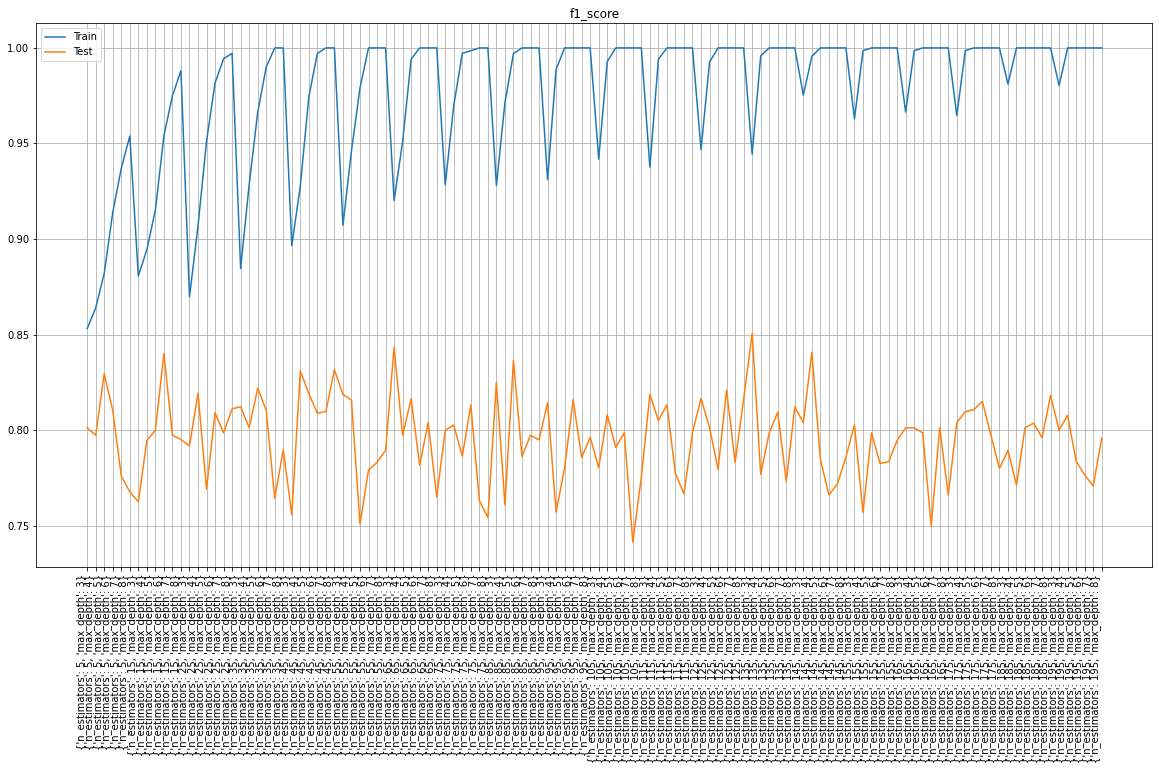

In [31]:
cheap_cols = list(types[types.feature_type.isin(['CT', 'H', 'G', 'E'])].feature)
cheap_params = [{'n_estimators': n, 'max_depth': d} for n, d in product(np.arange(5, 201, 10), np.arange(3, 9))]
cheap_model, cheap_training, cheap_score, cheap_param = optimize(df[cheap_cols + ['target']], 0.3, model_constructor, cheap_params, plot=True)

                  genetic  environmental     cheap
f1_score         0.796512       0.718121  0.850649
accuracy_score   0.740741       0.688889  0.829630
precision_score  0.756906       0.737931  0.867550
recall_score     0.840491       0.699346  0.834395


(0.0, 1.0)

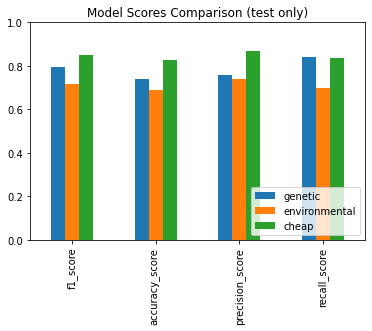

In [32]:
performance_df = pd.DataFrame([gen_score, env_score, cheap_score], index=['genetic', 'environmental', 'cheap']).T
print(performance_df)
performance_df.plot.bar()
plt.title('Model Scores Comparison (test only)')
plt.legend(loc=4)
plt.ylim([0, 1])

In [33]:
cheap_cols

['sex_F',
 'sex_M',
 'cp_type_atypical_angina',
 'cp_type_no_pain',
 'cp_type_non_anginal',
 'cp_type_typical_angina',
 'age',
 'blood_press_s_rest',
 'chol',
 'smoker',
 'smoker_cigs_per_day',
 'smoker_years',
 'fasting_blood_sugar',
 'heart_disease_family',
 'heart_rate_peak',
 'heart_rate_rest',
 'ex_angina']